<a href="https://colab.research.google.com/github/4datascience/Traffic/blob/master/Feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INITIALISATION**

## Python Environment

### Import Python libraries

In [1]:
# Data libraries
from google.colab import drive
import os
import pandas as pd
import calendar
import numpy as np
import gc
import math

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from seaborn import violinplot, boxenplot

# Model training
from sklearn.model_selection import cross_validate
from sklearn import metrics, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
#from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import base
    # Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Lambda
    # Tensorflow
import tensorflow as tf

# Statistical tests
from scipy.stats import shapiro

### SET ENVIRONMENT VARIABLES

In [2]:
# PREDICTION HORIZON
PREDICTED_MINUTES_AHEAD = 5
if (PREDICTED_MINUTES_AHEAD%5 != 0): raise ValueError("Invalid prediction horizon. Must be multiple of 5 minutes")
INPUT_MINUTES_BEFORE = 45
if (INPUT_MINUTES_BEFORE%5 != 0): raise ValueError("Invalid input minutes span. Must be multiple of 5 minutes")

## Files

### Mount \<Google Drive\>

In [3]:
drive.mount('/content/drive')
!rm -rf sample_data

Mounted at /content/drive


### Clone \<Github\>

In [ ]:
!sh /content/drive/MyDrive/Traffic/scripts/initialisation.sh

/content/drive/MyDrive/Traffic/scripts/initialisation.sh: 1: %cd: not found
Cloning into 'Traffic'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 104 (delta 42), reused 36 (delta 3), pack-reused 0
Receiving objects: 100% (104/104), 9.85 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/content/drive/MyDrive/Traffic/scripts/initialisation.sh: 3: %cd: not found


In [ ]:
%cd /content/Traffic
!git config user.email diego@google.colab.com
!git config user.name "Google Colab"
!git config http.postBuffer 524288000

/content/Traffic


#**UPLOAD DATA**

## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, LOS_DEP ]

In [ ]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7387200 elements):
	62.45434623813002%
Validation percentage:
	37.54261017774531%


## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, TT_ARR-5, TT_ARR-10, ..., TT_ARR-N, LOS_DEP ]

In [ ]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    for offset in range(1,int((INPUT_MINUTES_BEFORE)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    for offset in range(1,int((INPUT_MINUTES_BEFORE)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7386120 elements):
	62.44521548575602%
Validation percentage:
	37.54463923382843%


#**DOWNLOAD DATA**

## Without temporal information

In [3]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

## With temporal information

In [ ]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

# DATA EXPLORATION

## Visual

> Dataframe content

In [ ]:
training_df[training_df['link_id']==8].head(10)

,link_id,tt_arr,tt_arr-5,tt_arr-10,tt_arr-15,tt_arr-20,tt_arr-25,tt_arr-30,tt_arr-35,tt_arr-40,tt_arr-45,LOS_dep
date,,,,,,,,,,,,
2015-01-01 00:45:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:46:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:47:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:48:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:49:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:50:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:51:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:52:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:53:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1


In [ ]:
training_df[training_df['link_id']==5].sample(n=10)

,link_id,tt_arr,LOS_dep
date,,,
2016-06-04 12:35:00,5,291.0,1
2017-02-04 03:47:00,5,281.0,1
2015-12-04 14:02:00,5,688.0,4
2015-02-10 00:19:00,5,304.0,1
2015-06-18 17:21:00,5,320.0,1
2016-03-14 09:47:00,5,346.0,1
2017-09-09 13:20:00,5,507.0,1
2015-04-04 14:05:00,5,299.5,1
2018-08-11 12:26:00,5,373.0,1


> Per weekday link LOS histogram


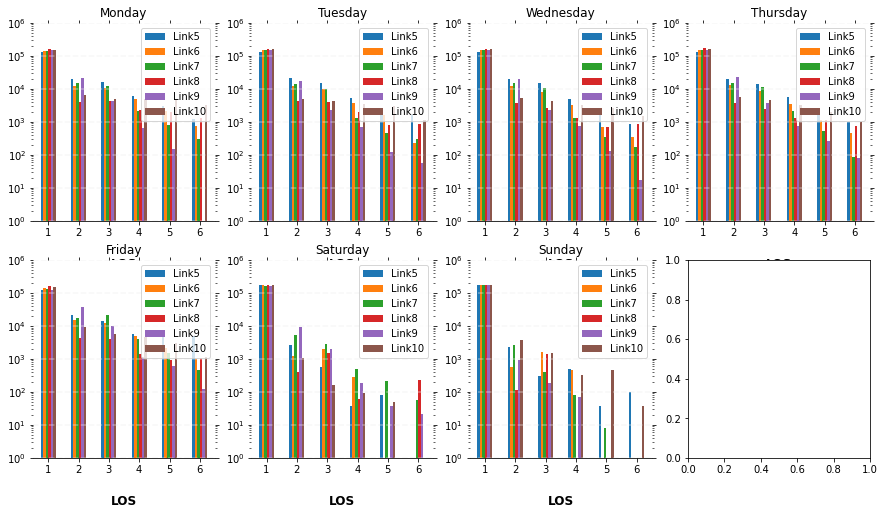

In [ ]:
dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(nrows=2, ncols=4)
for weekday in range(0,7):
    plot_df = pd.DataFrame(index=[i for i in range(1,7)])
    for LINK in range(5,11):
        plot_df[f'Link{LINK}'] = training_df[(training_df['link_id']==LINK) & (training_df.index.weekday == weekday)].groupby('LOS_dep')['tt_arr'].count()
    plot_df.fillna(0)
    
    plot_df.plot.bar(ax=axes[math.floor(weekday/4),weekday%4], rot=0, figsize=(15,8), log=True)
    # Set title
    axes[math.floor(weekday/4),weekday%4].set_title(f'{dias_semana[weekday]}')

for x_col in axes:
    for x in x_col:
        if x.get_title() != '':
            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Set y-lim
            x.set_ylim(top=1e6)

            # Set x-axis label
            x.set_xlabel(f"LOS", labelpad=20, weight='bold', size=12)

> Per hour link LOS histogram

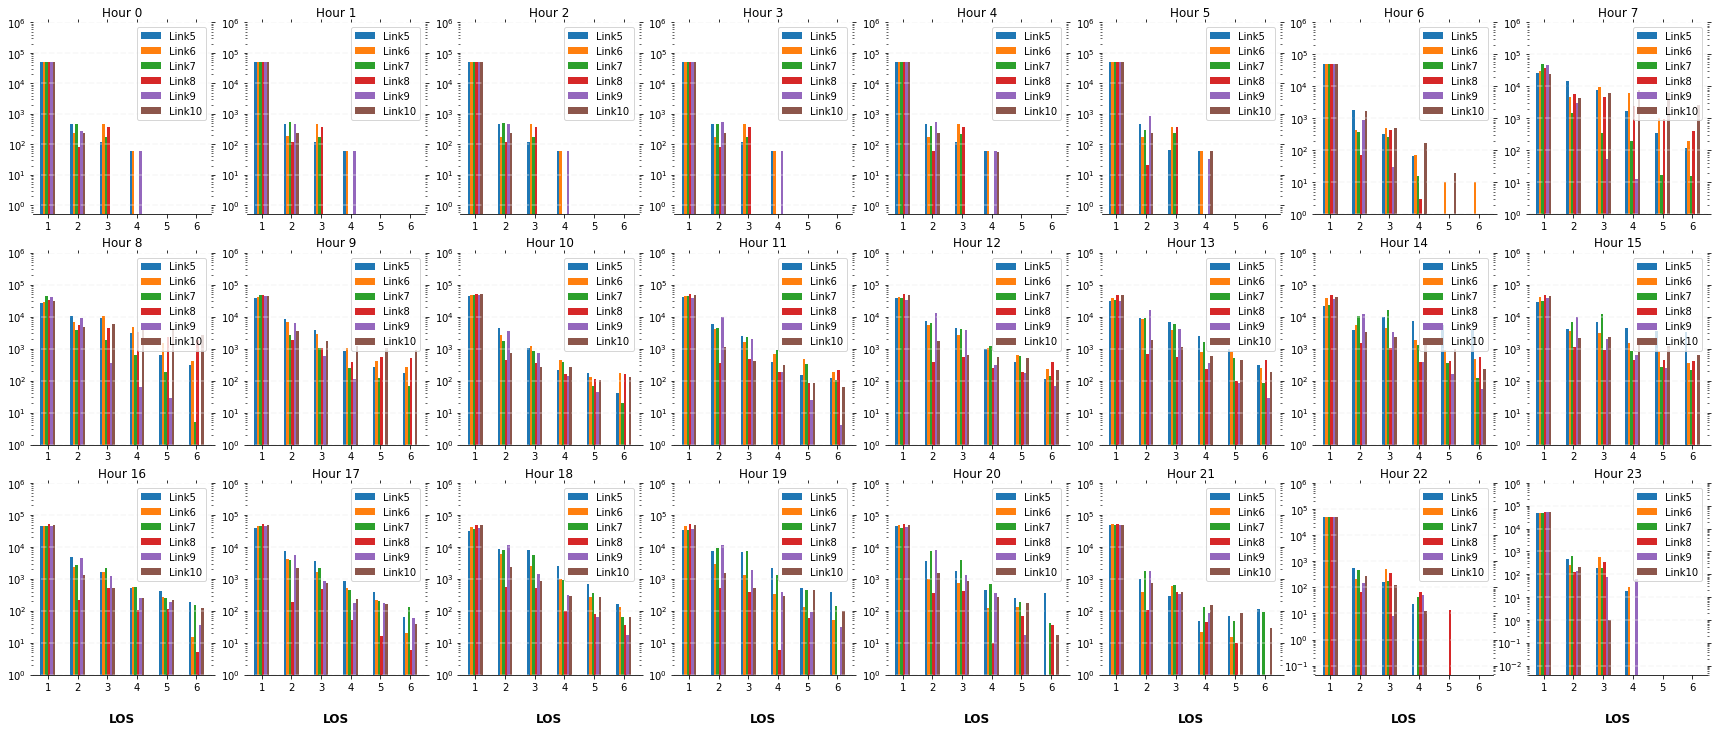

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=8)
for hour in range(0,24):
    plot_df = pd.DataFrame(index=[i for i in range(1,7)])
    for LINK in range(5,11):
        plot_df[f'Link{LINK}'] = training_df[(training_df['link_id']==LINK) & (training_df.index.hour == hour)].groupby('LOS_dep')['tt_arr'].count()
    plot_df.fillna(0)
    
    plot_df.plot.bar(ax=axes[math.floor(hour/8),hour%8], rot=0, figsize=(30,12), log=True)
    # Set title
    axes[math.floor(hour/8),hour%8].set_title(f'Hour {hour}')

for x_col in axes:
    for x in x_col:
        if x.get_title() != '':
            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Set y-lim
            x.set_ylim(top=1e6)

            # Set x-axis label
            x.set_xlabel(f"LOS", labelpad=20, weight='bold', size=12)

> Statistical distribution of Times of Arrival per Level of Service

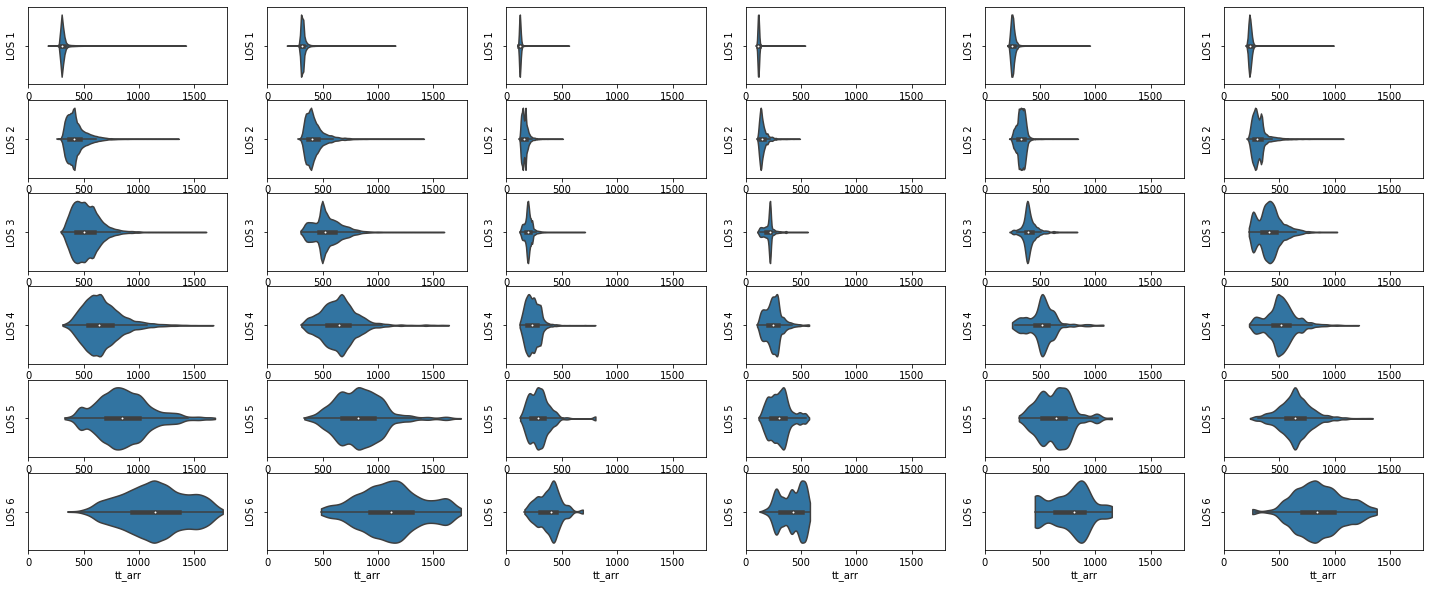

In [ ]:
fig, axs = plt.subplots(6,6)
fig.set_size_inches(25, 10)
for LINK in range(5,11):
    plot_df=training_df[(training_df['link_id']==LINK)]

    # Plot violinplot tt_arr per LOS
    for LOS in range(1,7):
        axs[LOS-1,LINK-5].set(xlim=(0, 1800))
        violinplot(data=plot_df[plot_df["LOS_dep"] == LOS], x="tt_arr", cut=0, ax=axs[LOS-1,LINK-5]).set(ylabel=f"LOS {LOS}")

## Statistical

> Features available

In [ ]:
training_df[['link_id','tt_arr','LOS_dep']].describe()

,link_id,tt_arr,LOS_dep
count,7.386120e+06,7.386120e+06,7.386120e+06
mean,7.500000e+00,2.466202e+02,1.214961e+00
std,1.707825e+00,1.247695e+02,6.847303e-01
min,5.000000e+00,9.400000e+01,1.000000e+00
25%,6.000000e+00,1.250000e+02,1.000000e+00
50%,7.500000e+00,2.440000e+02,1.000000e+00
75%,9.000000e+00,3.080000e+02,1.000000e+00
max,1.000000e+01,1.756500e+03,6.000000e+00


> Per-link id data balance





In [ ]:
training_df[training_df['LOS_dep']==4]['link_id'].value_counts()[training_df.link_id.unique()]

5     28407
6     20875
7     11497
8      8188
9      4173
10    20101
Name: link_id, dtype: int64

> Test normality of Times of Arrival

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    for LOS in range(1,7):
        print(f"\tLOS {LOS}\tPvalue {shapiro(training_df[(training_df['link_id']==LINK) & (training_df['LOS_dep']==LOS)]['tt_arr']).pvalue}")

LINK 5
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 3.0895828541433567e-41
	LOS 6	Pvalue 5.011837864629182e-29
LINK 6
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 8.23121877165319e-39
	LOS 6	Pvalue 1.0535939090175312e-16
LINK 7
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 0.0
	LOS 6	Pvalue 6.297267937140083e-13
LINK 8
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 2.802596928649634e-45
	LOS 5	Pvalue 5.859512404482781e-33
	LOS 6	Pvalue 2.4114945272565777e-41
LINK 9
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 1.3216130666316006e-38
	LOS 5	Pvalue 3.42259417150919e-14
	LOS 6	Pvalue 7.32835389594122e-11
LINK 10
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 1.401298464324817e-45
	LOS 6	Pvalue 1.0998466610191978e-22


# **NAIVE BAYES**

## **NO FEATURE ENGINEERING**

### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X_train = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y_train = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1) )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 97.23%
	LOS 2: Recall 53.06%
	LOS 3: Recall 40.82%
	LOS 4: Recall 21.36%
	LOS 5: Recall 22.88%
	LOS 6: Recall 59.9%
LINK 6
	LOS 1: Recall 96.11%
	LOS 2: Recall 34.04%
	LOS 3: Recall 33.21%
	LOS 4: Recall 15.45%
	LOS 5: Recall 17.77%
	LOS 6: Recall 34.31%
LINK 7
	LOS 1: Recall 98.42%
	LOS 2: Recall 57.11%
	LOS 3: Recall 46.48%
	LOS 4: Recall 13.87%
	LOS 5: Recall 16.24%
	LOS 6: Recall 30.1%
LINK 8
	LOS 1: Recall 99.53%
	LOS 2: Recall 37.57%
	LOS 3: Recall 80.84%
	LOS 4: Recall 8.35%
	LOS 5: Recall 8.25%
	LOS 6: Recall 60.68%
LINK 9
	LOS 1: Recall 97.78%
	LOS 2: Recall 74.72%
	LOS 3: Recall 27.35%
	LOS 4: Recall 37.26%
	LOS 5: Recall 12.93%
	LOS 6: Recall 28.05%
LINK 10
	LOS 1: Recall 99.24%
	LOS 2: Recall 46.15%
	LOS 3: Recall 33.92%
	LOS 4: Recall 33.91%
	LOS 5: Recall 46.21%
	LOS 6: Recall 46.8%


## **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

### *Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df[training_df['link_id'] == LINK].copy()

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X_train = training_df_link.filter(regex=("tt_ar[^-]+$")).values
    y_train = training_df_link['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_ar[^-]+$")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 94.71%
	LOS 2: Recall 45.1%
	LOS 3: Recall 38.25%
	LOS 4: Recall 20.15%
	LOS 5: Recall 24.19%
	LOS 6: Recall 59.22%
LINK 6
	LOS 1: Recall 92.41%
	LOS 2: Recall 38.44%
	LOS 3: Recall 46.79%
	LOS 4: Recall 17.23%
	LOS 5: Recall 26.79%
	LOS 6: Recall 35.65%
LINK 7
	LOS 1: Recall 92.15%
	LOS 2: Recall 61.94%
	LOS 3: Recall 42.9%
	LOS 4: Recall 14.3%
	LOS 5: Recall 12.48%
	LOS 6: Recall 47.77%
LINK 8
	LOS 1: Recall 94.01%
	LOS 2: Recall 60.07%
	LOS 3: Recall 76.98%
	LOS 4: Recall 19.58%
	LOS 5: Recall 10.38%
	LOS 6: Recall 62.61%
LINK 9
	LOS 1: Recall 91.33%
	LOS 2: Recall 66.3%
	LOS 3: Recall 34.29%
	LOS 4: Recall 35.3%
	LOS 5: Recall 24.19%
	LOS 6: Recall 31.44%
LINK 10
	LOS 1: Recall 92.21%
	LOS 2: Recall 52.36%
	LOS 3: Recall 29.03%
	LOS 4: Recall 25.99%
	LOS 5: Recall 37.58%
	LOS 6: Recall 49.08%


## **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

### *Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

### *Validation*

In [ ]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df[training_df['link_id'] == LINK].copy()

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X_train = training_df_link.filter(regex=("tt_arr.*")).values
    y_train = training_df_link['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_arr.*")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 92.13%
	LOS 2: Recall 39.55%
	LOS 3: Recall 29.16%
	LOS 4: Recall 19.54%
	LOS 5: Recall 23.77%
	LOS 6: Recall 62.57%
LINK 6
	LOS 1: Recall 89.42%
	LOS 2: Recall 33.89%
	LOS 3: Recall 39.04%
	LOS 4: Recall 15.23%
	LOS 5: Recall 22.03%
	LOS 6: Recall 41.77%
LINK 7
	LOS 1: Recall 88.72%
	LOS 2: Recall 58.36%
	LOS 3: Recall 28.98%
	LOS 4: Recall 20.79%
	LOS 5: Recall 11.4%
	LOS 6: Recall 37.96%
LINK 8
	LOS 1: Recall 89.82%
	LOS 2: Recall 32.24%
	LOS 3: Recall 68.63%
	LOS 4: Recall 34.23%
	LOS 5: Recall 15.5%
	LOS 6: Recall 48.55%
LINK 9
	LOS 1: Recall 87.66%
	LOS 2: Recall 53.49%
	LOS 3: Recall 17.93%
	LOS 4: Recall 3.58%
	LOS 5: Recall 16.82%
	LOS 6: Recall 47.88%
LINK 10
	LOS 1: Recall 87.75%
	LOS 2: Recall 33.32%
	LOS 3: Recall 17.89%
	LOS 4: Recall 17.53%
	LOS 5: Recall 19.25%
	LOS 6: Recall 48.41%


# **RUSBoost**

## **MANUAL RUS**

This implementation validates that the performance acchieved with the RUSBoost algorithm is consistent with a first approach of Random Undersampling and posterior training.

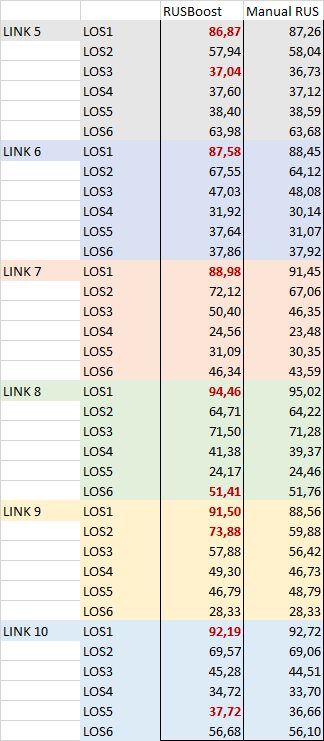

### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    n = min(training_df[training_df['link_id'] == LINK].groupby('LOS_dep')['tt_arr'].count())
    X = np.empty(0)
    y = np.empty(0)
    for LOS in range(1,7):
        training_df_LOS = training_df[(training_df['link_id'] == LINK) & (training_df['LOS_dep'] == LOS)].sample(n)[['tt_arr','LOS_dep']]
        X = np.append(X, training_df_LOS['tt_arr'].values)
        y = np.append(y, training_df_LOS['LOS_dep'].values)
    X = X.reshape(-1, 1)

    model = DecisionTreeClassifier(max_depth=64).fit(X, y)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 87.26%
	LOS 2: Recall 58.04%
	LOS 3: Recall 36.73%
	LOS 4: Recall 37.12%
	LOS 5: Recall 38.59%
	LOS 6: Recall 63.68%
LINK 6
	LOS 1: Recall 88.45%
	LOS 2: Recall 64.12%
	LOS 3: Recall 48.08%
	LOS 4: Recall 30.14%
	LOS 5: Recall 31.07%
	LOS 6: Recall 37.92%
LINK 7
	LOS 1: Recall 91.45%
	LOS 2: Recall 67.06%
	LOS 3: Recall 46.35%
	LOS 4: Recall 23.48%
	LOS 5: Recall 30.35%
	LOS 6: Recall 43.59%
LINK 8
	LOS 1: Recall 95.02%
	LOS 2: Recall 64.22%
	LOS 3: Recall 71.28%
	LOS 4: Recall 39.37%
	LOS 5: Recall 24.46%
	LOS 6: Recall 51.76%
LINK 9
	LOS 1: Recall 88.56%
	LOS 2: Recall 59.88%
	LOS 3: Recall 56.42%
	LOS 4: Recall 46.73%
	LOS 5: Recall 48.79%
	LOS 6: Recall 28.33%
LINK 10
	LOS 1: Recall 92.72%
	LOS 2: Recall 69.06%
	LOS 3: Recall 44.51%
	LOS 4: Recall 33.7%
	LOS 5: Recall 36.66%
	LOS 6: Recall 56.1%


## **NO FEATURE ENGINEERING**

### *Validation*

In [82]:
training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
    break
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

Sevilla_2015.csv 365.0


In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values

    model = RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=128), n_estimators=60, learning_rate=0.3).fit(X, y)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

In [109]:
def labelToIndex(i,clf):
    return clf.labelDict[i]

def indexToLabel(i,clf):
    return clf.classes[i]

class RusBoostClassifier:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = [None]*n_estimators
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        
    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching df column names that contain the features
        param y_column: name of df column name that contains the labels
        """
        
        N = df.shape[0]
        w = {epoch: 1/N for epoch in np.int32(df.index.astype(np.int64)/1e9)}
        
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)
        undersampling_n = min(df[y_column].value_counts())
        
        for m in range(self.n_estimators):
            
            df_ = pd.DataFrame()
            for label_ in self.classes:
                # Quizas muestrear usando la inversa de los pesos (.sample(weights=1/w)) para hacer overfit en los casos con menos error == underfit
                df_ = pd.concat([ df_, df[ df[y_column]==label_ ].sample(undersampling_n, replace=False) ])
            
            w_indices_ = np.int32(df_.index.astype(np.int64)/1e9)
            w_ = np.array([w[i] for i in w_indices_])

            X_ = df_.filter(regex=(X_columns)).values
            y_ = df_[y_column].values

            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=w_).predict
            
            incorrect = Gm(X_) != y_
            errM = np.average(incorrect,weights=w_,axis=0)
            
            self.estimator_errors_.append(errM)
            
            BetaM = np.log((1-errM)/errM)+np.log(k-1)
            incorrect_ = incorrect*(w_ > 0)
            for i, j in enumerate(w_indices_):
                w[j] *= np.exp(self.learning_rate* BetaM*incorrect_[i])
            
            self.models[m] = (BetaM,Gm)
        self.weights = w

        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i

    def predict(self,X):
        k = len(self.classes)
        Bms_ = [Bm for Bm,Gm in self.models]
        prob_matrix = np.full((X.shape[0],k), -sum(Bms_)/(k-1))
        
        # Obtain the predicted index array with shape (#obs,#weak_learners)
        iTL = np.vectorize(labelToIndex)
        y_pred = np.stack([iTL(Gm(X),self) for Bm,Gm in self.models], axis=-1)

        # Weight the indices count using Bm associated to each weak_learner
        prob_matrix += np.apply_along_axis(lambda x: np.bincount(x, weights=Bms_, minlength=k), axis=1, arr=y_pred)*k/(k-1)
        
        iTL = np.vectorize(indexToLabel)
        return iTL(np.argmax(prob_matrix,axis=1),self)

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.weights)), model.weights)

ax.set(xlabel='Observation', ylabel='weight',
       title='Weight per observation')
ax.grid()
plt.show()

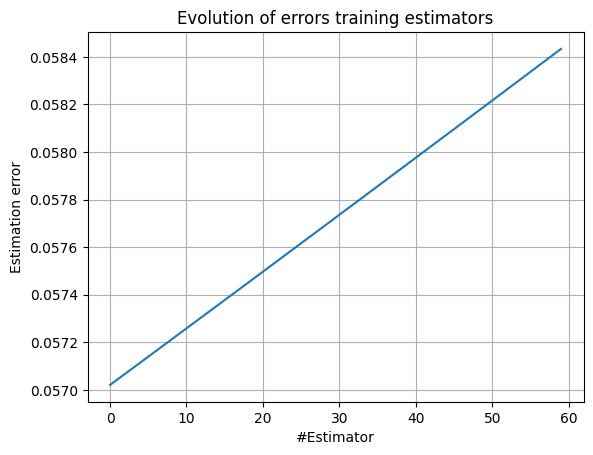

In [104]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

In [110]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values

    model = RusBoostClassifier(n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr', 'LOS_dep')

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 0.0%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 5.09%
	LOS 6: Recall 98.44%
LINK 6
	LOS 1: Recall 0.0%
	LOS 2: Recall 80.29%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 100.0%
LINK 7


KeyboardInterrupt: ignored

## **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

### *Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X = training_df_link.filter(regex=("tt_ar[^-]+$")).values
    y = training_df_link['LOS_dep'].values    

    sc = preprocessing.StandardScaler()
    X = sc.fit_transform(X)

    model = RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=128), n_estimators=60, learning_rate=0.3).fit(X, y)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_ar[^-]+$")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

### *Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

## **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

### *Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

### *Validation*

In [ ]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X = training_df_link.filter(regex=("tt_arr.*")).values
    y = training_df_link['LOS_dep'].values    

    sc = preprocessing.StandardScaler()
    X = sc.fit_transform(X)

    model = RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=128), n_estimators=60, learning_rate=0.3).fit(X, y)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_arr.*")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

# **LSTM**

## **NO FEATURE ENGINEERING**

**TRAIN or LOAD switch**

In [ ]:
train_again = False

### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    
    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    # Min-Max Scaling
    sc = preprocessing.MinMaxScaler().fit(np.array([[X[:,0].max()]*X.shape[1], [X[:,0].min()]*X.shape[1]]))
    
    if train_again:
        X = sc.transform(X)
        X = np.expand_dims(X, axis=2)
        print(f'Size of training data array {X.shape}')
        y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()
        print(f'Size of training labels {y.shape}')

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=100,
                return_sequences=True))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.LSTM(
                units=50,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=6, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=500, validation_split=0, verbose=1)

        model.save(f'/content/Traffic/models/LSTM_link{LINK}_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed.h5')
    
    else:
        model = keras.models.load_model(f'/content/Traffic/models/LSTM_link{LINK}_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed.h5')
    
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].filter(regex=("tt_arr.*")).values )
        X_test = np.expand_dims(X_test, axis=2)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

LINK 5
17717/17717 [==============================] - 50s 3ms/step
	LOS 1: Recall 96.67%
2564/2564 [==============================] - 8s 3ms/step
	LOS 2: Recall 52.13%
1647/1647 [==============================] - 4s 3ms/step
	LOS 3: Recall 62.17%
635/635 [==============================] - 2s 3ms/step
	LOS 4: Recall 24.53%
322/322 [==============================] - 1s 3ms/step
	LOS 5: Recall 33.63%
247/247 [==============================] - 1s 3ms/step
	LOS 6: Recall 62.68%
LINK 6
19747/19747 [==============================] - 57s 3ms/step
	LOS 1: Recall 97.78%
1299/1299 [==============================] - 3s 3ms/step
	LOS 2: Recall 32.92%
1465/1465 [==============================] - 4s 3ms/step
	LOS 3: Recall 75.37%
425/425 [==============================] - 1s 3ms/step
	LOS 4: Recall 22.16%
142/142 [==============================] - 0s 3ms/step
	LOS 5: Recall 29.02%
54/54 [==============================] - 0s 3ms/step
	LOS 6: Recall 47.26%
LINK 7
19655/19655 [==========================

## **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

**TRAIN or LOAD switch**

In [ ]:
train_again = True

### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)

    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    # Min-Max Scaling per Link
    sc = {}
    sc[LINK] = preprocessing.MinMaxScaler().fit(np.array([[X[:,0].max()]*X.shape[1], [X[:,0].min()]*X.shape[1]]))
    X = sc[LINK].transform(X)
    X = np.expand_dims(X, axis=2)

    for other_link in other_links:
        temp = training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
        sc[other_link] = preprocessing.MinMaxScaler().fit(np.array([[temp[:,0].max()]*temp.shape[1], [temp[:,0].min()]*temp.shape[1]]))
        temp = sc[other_link].transform(temp)
        X = np.concatenate( (X, np.expand_dims(temp, axis=2)) , axis=2)
        
    if train_again:
        print(f'Size of training data array {X.shape}')
        y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()
        print(f'Size of training labels {y.shape}')

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=100,
                return_sequences=True))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.LSTM(
                units=50,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=6, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=500, validation_split=0, verbose=1)

        model.save(f'/content/Traffic/models/LSTM_link{LINK}_adjacent_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed.h5')
    
    else:
        model = keras.models.load_model(f'/content/Traffic/models/LSTM_link{LINK}_adjacent_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed.h5')
    
    for LOS in range(1,7):        
        X_test = sc[LINK].transform( validation_df[validation_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values )
        X_test = np.expand_dims(X_test, axis=2)

        for other_link in other_links:
            temp = validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
            temp = sc[other_link].transform(temp)
            X_test = np.concatenate( (X_test, np.expand_dims(temp, axis=2)) , axis=2)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

LINK 5
Size of training data array (1231020, 10, 6)
Size of training labels (1231020, 6)
Epoch 1/10
2463/2463 [==============================] - 21s 7ms/step - loss: 0.3747 - accuracy: 0.8492
Epoch 2/10
2463/2463 [==============================] - 18s 7ms/step - loss: 0.3271 - accuracy: 0.8618
Epoch 3/10
2463/2463 [==============================] - 17s 7ms/step - loss: 0.3190 - accuracy: 0.8657
Epoch 4/10
2463/2463 [==============================] - 17s 7ms/step - loss: 0.3136 - accuracy: 0.8682
Epoch 5/10
2463/2463 [==============================] - 17s 7ms/step - loss: 0.3094 - accuracy: 0.8704
Epoch 6/10
2463/2463 [==============================] - 18s 7ms/step - loss: 0.3067 - accuracy: 0.8718
Epoch 7/10
2463/2463 [==============================] - 17s 7ms/step - loss: 0.3034 - accuracy: 0.8732
Epoch 8/10
2463/2463 [==============================] - 17s 7ms/step - loss: 0.3005 - accuracy: 0.8744
Epoch 9/10
2463/2463 [==============================] - 17s 7ms/step - loss: 0.2983 - a

## **FEATURE ENGINEERING CLASS BALANCING BY RUS**

# **CLEAN UP**

In [ ]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git pull

## COMMIT AND REMOVE

In [ ]:
%cd /content/Traffic
!sh /content/drive/MyDrive/Traffic/scripts/logout.sh

/content/Traffic
: not found
fatal: pathspec '.?' did not match any files
On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
Everything up-to-date


In [ ]:
drive.flush_and_unmount()
!rm -rf /content/Traffic

ValueError: ignored